In [1]:
# import transformers
from datasets import load_dataset
# from transformers import AutoModelForQuestionAnswering, BertModel, BertConfig, BertTokenizer, pipeline, AutoTokenizer
from transformers import AutoModelForQuestionAnswering, BertTokenizer, pipeline, AutoTokenizer
from tqdm import tqdm
import torch
import torch.nn as nn
import nltk



dataset = load_dataset("squad")
train = dataset['train']
validation = dataset['validation']

question_answerer = pipeline("question-answering", model='AliHashish/distilbert-base-uncased-finetuned-squad-EZcufe')
model_checkpoint = "atharvamundada99/bert-large-question-answering-finetuned-legal"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
pretrained_model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Found cached dataset parquet (C:/Users/DELL/.cache/huggingface/datasets/parquet/plain_text-57edf78d6033ac9a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [25]:
# model = CustomBertForQuestionAnswering(config)
# model.load_state_dict(torch.load('model.pth'), strict=False)
model_checkpoint = "atharvamundada99/bert-large-question-answering-finetuned-legal"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [68]:
total = 0
correct = 0
EM = 0
BLEU = 0
errors = []
for record in tqdm(validation):
        # try:
                total += 1
                if total == 1001:
                        break
                if (total % 200 == 0):
                        print(f"Correct:\t {correct}, out of {total}: {100*correct/total}%")
                        print(f"EM:\t\t\t {EM}, out of {total}: {100*EM/total}%")
                        print(f"BLEU:\t\t\t {BLEU}, out of {total}: {100*BLEU/total}%")
                # result = question_answerer(question=record['question'], context=record['context'], truncation=True, padding=True, return_tensors='pt')
                result = QA(model, tokenizer,record['question'], record['context'])
                # n = min(len(result['answer'].split()), 4)
                n = min(len(result.split()), 4)
                if n == 0:
                        BLEUscore = 0
                else:
                        weights = [1.0/n]*n
                        BLEUscore = nltk.translate.bleu_score.sentence_bleu([record['answers']['text'][0].lower()], result.lower(), weights=weights)
                if result != '' and (result.lower() in record['answers']['text'][0].lower() or record['answers']['text'][0].lower() in result.lower()):
                        correct += 1
                if record['answers']['text'][0].lower() == result.lower():
                        EM += 1
                if BLEUscore > 0.5:
                        BLEU += 1
        # except Exception as e:
        #         errors.append(total)
        #         print(f"Error at {total}: {e}")
        #         continue
print(f"Correct: {correct}, out of {total}: {100*correct/total}%")
print(f"EM: {EM}, out of {total}: {100*EM/total}%")
print(f"BLEU: {BLEU}, out of {total}: {100*BLEU/total}%")


  2%|▏         | 199/10570 [01:40<3:01:45,  1.05s/it]

Correct:	 30, out of 200: 15.0%
EM:			 1, out of 200: 0.5%
BLEU:			 3, out of 200: 1.5%


  4%|▍         | 398/10570 [05:14<2:13:47,  1.27it/s]


KeyboardInterrupt: 

In [ ]:
# # dh 3lshan ykamel fl iteration lw w2fna fl nos

# print(f"Accuracy: {100*correct/total}")
# print(f"Correct: {correct}, out of {total}")
# print(f"Errors: {errors}")
# prev_total = total
# total = 0
# for record in tqdm(validation):
#         try:
#                 total += 1
#                 if total < prev_total:
#                         continue
#                 if (total % 1000 == 0):
#                         print(f"Accuracy: {100*correct/total}")
#                         print(f"Correct: {correct}, out of {total}")
#                         print(f"EM: {EM}, out of {total}: {100*EM/total}%")
#                         print(f"BLEU: {BLEU}, out of {total}: {100*BLEU/total}%")
#                 result = question_answerer(question=record['question'], context=record['context'], truncation=True, padding=True, return_tensors='pt')
#                 BLEUscore = nltk.translate.bleu_score.sentence_bleu([record['answers']['text'][0].lower()], result['answer'].lower())
#                 if result['answer'].lower() in record['answers']['text'][0].lower() or record['answers']['text'][0].lower() in result['answer'].lower():
#                         correct += 1
#                 if record['answers']['text'][0].lower() == result['answer'].lower():
#                         EM += 1
#                 if BLEUscore > 0.5:
#                         BLEU += 1

#         except Exception as e:
#                 errors.append(total)
#                 print(f"Error at {total}: {e}")
#                 continue

# print(f"Accuracy: {100*correct/total}")
# print(f"Correct: {correct}, out of {total}")
# print(f"EM: {EM}, out of {total}: {100*EM/total}%")
# print(f"BLEU: {BLEU}, out of {total}: {100*BLEU/total}%")


In [ ]:
# # get model architecture
# print("model.config: ", pretrained_model.config)
# print("============================================================================================")

# # get model parameters
# print("model.parameters: ", pretrained_model.parameters)
# print("============================================================================================")

# # get model layers
# print("model.layers: ", pretrained_model.bert.encoder.layer)
# print("============================================================================================")

# # get model weights
# print("model.weights: ", pretrained_model.state_dict())
# print("============================================================================================")

# print("model.layers: ", len(pretrained_model.bert.encoder.layer))



In [ ]:
class CustomBertForQuestionAnswering(nn.Module):
    def __init__(self, config):
        super(CustomBertForQuestionAnswering, self).__init__()
        self.config = config  # Attach the config object as an attribute
        self.bert = BertModel(config)
        self.qa_outputs = nn.Linear(config.hidden_size, 2)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state
        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
        return start_logits, end_logits

# Instantiate the model with the provided configuration
config = BertConfig.from_dict({
    "_name_or_path": "ourModel",
    "architectures": [
        "BertForQuestionAnswering"
    ],
    "attention_probs_dropout_prob": 0.1,
    "gradient_checkpointing": False,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 1024,
    "initializer_range": 0.02,
    "intermediate_size": 4096,
    "layer_norm_eps": 1e-12,
    "max_position_embeddings": 512,
    "model_type": "bert",
    "num_attention_heads": 16,
    "num_hidden_layers": 24,
    "pad_token_id": 0,
    "position_embedding_type": "absolute",
    "transformers_version": "4.17.0",
    "type_vocab_size": 2,
    "use_cache": True,
    "vocab_size": 30522
})

model = CustomBertForQuestionAnswering(config)


In [ ]:
# Get state dictionary of pre-trained model
pretrained_dict = pretrained_model.state_dict()

# Get state dictionary of custom model
model_dict = model.state_dict()

print(len(pretrained_dict))

# Filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print(len(pretrained_dict))

# Overwrite entries in the existing state dict
model_dict.update(pretrained_dict)

# Load the new state dict
model.load_state_dict(model_dict)

# Building BERT

In [2]:
class BertConfig:
    def __init__(self, vocab_size=30522, hidden_size=1024, num_hidden_layers=24, intermediate_size=4096, num_attention_heads=16, attention_probs_dropout_prob=0.1, max_position_embeddings=512, type_vocab_size=2, **kwargs):
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.intermediate_size = intermediate_size
        self.num_attention_heads = num_attention_heads
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        for key, value in kwargs.items():
            setattr(self, key, value)

    @classmethod
    def from_dict(cls, json_object):
        return cls(**json_object)

    def to_dict(self):
        return self.__dict__

In [55]:
import torch.nn as nn

# class BertEmbeddings(nn.Module):
#     def __init__(self, vocab_size=30522, hidden_size=1024, pad_token_id=0, max_position_embeddings=512, type_vocab_size=2):
#         super(BertEmbeddings, self).__init__()
#         self.word_embeddings = nn.Embedding(vocab_size, hidden_size, padding_idx=pad_token_id)
#         self.position_embeddings = nn.Embedding(max_position_embeddings, hidden_size)
#         self.token_type_embeddings = nn.Embedding(type_vocab_size, hidden_size)
#         self.position_ids = torch.arange(max_position_embeddings).unsqueeze(0)

#         # LayerNorm and dropout Module
#         self.LayerNorm = nn.LayerNorm(hidden_size, eps=1e-12)
#         self.dropout = nn.Dropout(0.1)

#     def forward(self, input_ids=None, token_type_ids=None, position_ids=None):
#         seq_length = input_ids.size(1)
#         position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)  # create position_ids on the fly
#         position_embeddings = self.position_embeddings(position_ids)

#         if token_type_ids is None:
#             token_type_ids = torch.zeros_like(input_ids)

#         word_embeddings = self.word_embeddings(input_ids)
#         token_type_embeddings = self.token_type_embeddings(token_type_ids)

#         embeddings = word_embeddings + position_embeddings + token_type_embeddings
#         embeddings = self.LayerNorm(embeddings)
#         embeddings = self.dropout(embeddings)
#         return embeddings

class BertEmbeddings(nn.Module):
    def __init__(self, vocab_size=30522, hidden_size=1024, pad_token_id=0, max_position_embeddings=512, type_vocab_size=2):
        super(BertEmbeddings, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, hidden_size, padding_idx=pad_token_id)
        self.position_embeddings = nn.Embedding(max_position_embeddings, hidden_size)
        self.token_type_embeddings = nn.Embedding(type_vocab_size, hidden_size)

        # Make position_ids a nn.Parameter
        self.position_ids = nn.Parameter(torch.arange(max_position_embeddings).unsqueeze(0), requires_grad=False)

        # LayerNorm and dropout Module
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids=None, token_type_ids=None, position_ids=None):
        if position_ids is None:
            position_ids = self.position_ids[:, :input_ids.size(1)]  # use pre-computed position_ids

        position_embeddings = self.position_embeddings(position_ids)

        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        word_embeddings = self.word_embeddings(input_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = word_embeddings + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

In [56]:
class BertSelfAttention(nn.Module):
    def __init__(self, hidden_size=1024, num_attention_heads=16, attention_probs_dropout_prob=0.1):
        super(BertSelfAttention, self).__init__()
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(attention_probs_dropout_prob)

    def forward(self, hidden_states, attention_mask=None):
        # Implement the forward pass
        query_states = self.query(hidden_states)
        key_states = self.key(hidden_states)
        value_states = self.value(hidden_states)

        # Compute the dot product between query and key states
        attention_scores = torch.matmul(query_states, key_states.transpose(-1, -2))

        # Apply the attention mask, if provided
        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        # Apply softmax to get the attention probabilities
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # Apply dropout
        attention_probs = self.dropout(attention_probs)

        # Multiply the attention probabilities with the value states
        context_layer = torch.matmul(attention_probs, value_states)

        return context_layer
        # pass

class BertSelfOutput(nn.Module):
    def __init__(self, hidden_size=1024, dropout_prob=0.1):
        super(BertSelfOutput, self).__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, hidden_states, input_tensor):
        # Implement the forward pass
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states
        # pass

In [57]:
class BertAttention(nn.Module):
    def __init__(self, hidden_size=1024, num_attention_heads=16, attention_probs_dropout_prob=0.1):
        super(BertAttention, self).__init__()
        self.self = BertSelfAttention(hidden_size, num_attention_heads, attention_probs_dropout_prob)
        self.output = BertSelfOutput(hidden_size, attention_probs_dropout_prob)

    def forward(self, input_tensor, attention_mask):
        # Implement the forward pass
        self_output = self.self(input_tensor, attention_mask)
        attention_output = self.output(self_output, input_tensor)
        return attention_output
        # pass

In [58]:
import torch.nn as nn
import torch.nn.functional as F

class GELUActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return F.gelu(x)

In [59]:
import torch.nn as nn
import torch.nn.functional as F

class BertIntermediate(nn.Module):
    def __init__(self, hidden_size=1024, intermediate_size=4096):
        super(BertIntermediate, self).__init__()
        self.dense = nn.Linear(hidden_size, intermediate_size)
        # self.intermediate_act_fn = F.gelu
        self.intermediate_act_fn = GELUActivation()

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        # hidden_states = self.intermediate_act_fn(hidden_states)
        hidden_states = F.gelu(hidden_states)
        return hidden_states

In [60]:
import torch.nn as nn

class BertOutput(nn.Module):
    def __init__(self, intermediate_size=4096, hidden_size=1024, dropout_prob=0.1):
        super(BertOutput, self).__init__()
        self.dense = nn.Linear(intermediate_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, hidden_states, input_tensor):
        # Implement the forward pass
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states
        # pass

In [61]:
import torch.nn as nn

class BertLayer(nn.Module):
    def __init__(self, hidden_size=1024, intermediate_size=4096, num_attention_heads=16, attention_probs_dropout_prob=0.1):
        super(BertLayer, self).__init__()
        self.attention = BertAttention(hidden_size, num_attention_heads, attention_probs_dropout_prob)
        self.intermediate = BertIntermediate(hidden_size, intermediate_size)
        self.output = BertOutput(intermediate_size, hidden_size, attention_probs_dropout_prob)

    def forward(self, hidden_states, attention_mask):
        # Implement the forward pass
        attention_output = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output
        # pass

class BertEncoder(nn.Module):
    def __init__(self, num_hidden_layers=24, hidden_size=1024, intermediate_size=4096, num_attention_heads=16, attention_probs_dropout_prob=0.1):
        super(BertEncoder, self).__init__()
        self.layer = nn.ModuleList([BertLayer(hidden_size, intermediate_size, num_attention_heads, attention_probs_dropout_prob) for _ in range(num_hidden_layers)])

    def forward(self, hidden_states, attention_mask):
        # Implement the forward pass
        for layer in self.layer:
            hidden_states = layer(hidden_states, attention_mask)
        return hidden_states
        # pass

In [62]:
# import torch.nn as nn

# class BertPooler(nn.Module):
#     def __init__(self, hidden_size=1024):
#         super(BertPooler, self).__init__()
#         self.dense = nn.Linear(hidden_size, hidden_size)
#         self.activation = nn.Tanh()

#     def forward(self, hidden_states):
#         # We "pool" the model by simply taking the hidden state corresponding to the first token.
#         first_token_tensor = hidden_states[:, 0]
#         pooled_output = self.dense(first_token_tensor)
#         pooled_output = self.activation(pooled_output)
#         return pooled_output

In [63]:
import torch.nn as nn

class BertModel(nn.Module):
    def __init__(self, vocab_size=30522, hidden_size=1024, num_hidden_layers=24, intermediate_size=4096, num_attention_heads=16, attention_probs_dropout_prob=0.1, pad_token_id = 0, max_position_embeddings=512, type_vocab_size=2):
        super(BertModel, self).__init__()
        self.embeddings = BertEmbeddings(vocab_size, hidden_size, pad_token_id, max_position_embeddings, type_vocab_size)
        self.encoder = BertEncoder(num_hidden_layers, hidden_size, intermediate_size, num_attention_heads, attention_probs_dropout_prob)
        # self.pooler = BertPooler(hidden_size)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # Implement the forward pass
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype) # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        embedding_output = self.embeddings(input_ids, token_type_ids)
        encoder_output = self.encoder(embedding_output, extended_attention_mask)
        # pooled_output = self.pooler(encoder_output)

        return encoder_output  # or return pooled_output if you want to use the pooler
        # pass

In [64]:
import torch.nn as nn
    
class BertForQuestionAnswering(nn.Module):
    def __init__(self, config):
        super(BertForQuestionAnswering, self).__init__()
        self.config = config
        self.bert = BertModel(vocab_size=config.vocab_size, hidden_size=config.hidden_size, num_hidden_layers=config.num_hidden_layers, intermediate_size=config.intermediate_size, num_attention_heads=config.num_attention_heads, attention_probs_dropout_prob=config.attention_probs_dropout_prob, pad_token_id=config.pad_token_id ,max_position_embeddings=config.max_position_embeddings, type_vocab_size=config.type_vocab_size)
        self.qa_outputs = nn.Linear(config.hidden_size, 2)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        sequence_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
        return start_logits, end_logits

# Instantiate the model with the provided configuration
config = BertConfig.from_dict({
    "_name_or_path": "ourModel",
    "architectures": [
        "BertForQuestionAnswering"
    ],
    "attention_probs_dropout_prob": 0.1,
    "gradient_checkpointing": False,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 1024,
    "initializer_range": 0.02,
    "intermediate_size": 4096,
    "layer_norm_eps": 1e-12,
    "max_position_embeddings": 512,
    "model_type": "bert",
    "num_attention_heads": 16,
    "num_hidden_layers": 24,
    "pad_token_id": 0,
    "position_embedding_type": "absolute",
    "transformers_version": "4.17.0",
    "type_vocab_size": 2,
    "use_cache": True,
    "vocab_size": 30522
})

model = BertForQuestionAnswering(config)

In [65]:
# Get state dictionary of pre-trained model
pretrained_dict = pretrained_model.state_dict()

# Get state dictionary of custom model
model_dict = model.state_dict()

print(len(pretrained_dict))

# Check the keys that are not in the model_dict
for k, v in pretrained_dict.items():
    if k not in model_dict:
        print(k, ":", v.shape)

# Filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

print(len(pretrained_dict))

# Overwrite entries in the existing state dict
model_dict.update(pretrained_dict)

# Load the new state dict
model.load_state_dict(model_dict)

392
392


<All keys matched successfully>

In [67]:
model.eval()
print(model.training)

False


In [51]:
pretrained_model.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), ep

In [ ]:
model.eval()
CustomBertForQuestionAnswering(
    
  (bert): BertModel(      # (esm el module): esm el class(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      # 30522: vocab size (el number of unique words the layer can handle)
      # 1024: size of embedding vector (kol kelma bt3ml vector 1024 elements)
      # padding_idx=0: y3ny index 0 fl vocab htb2a padding
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): BertIntermediate(
            (dense): Linear(in_features=1024, out_features=4096, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): BertOutput(
            (dense): Linear(in_features=4096, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
  )
  (qa_outputs): Linear(in_features=1024, out_features=2, bias=True)
)

In [ ]:
print(model.training)

In [24]:
# Save model
torch.save(model.state_dict(), 'model2.pth')

In [ ]:
# Load model
model = CustomBertForQuestionAnswering(config)
model.load_state_dict(torch.load('model2.pth'))


In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


In [26]:
def QA(model, tokenizer, question, context):
    # Process the inputs
    inputs = tokenizer(question, context, return_tensors='pt')

    # Pass the inputs through the model and get the start and end scores
    start_scores, end_scores = model(**inputs)

    # Get the start and end positions
    start_position = torch.argmax(start_scores)
    end_position = torch.argmax(end_scores)

    # Get the answer
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][start_position:end_position+1]))

    return answer

def QAs(model, tokenizer, questions, contexts):
    answers = []
    for question, context in zip(questions, contexts):
        answer = QA(model, tokenizer, question, context)
        answers.append(answer)
    return answers

def Evaluation(model, tokenizer, validation):
    correct = 0
    EM = 0
    total = 0
    errors = []
    for record in tqdm(validation):
        try:
            total += 1
            if (total % 500 == 0):
                print(f"\nAccuracy: {100*correct/total}")
                print(f"Correct: {correct}, out of {total}")
                print(f"EM: {100*EM/total}")
                print(f"EM Correct: {EM}, out of {total}\n")

            predicted_answer = QA(model, tokenizer, record['question'], record['context'])
            if predicted_answer.lower() in record['answers']['text'][0].lower() or record['answers']['text'][0].lower() in predicted_answer.lower():
                correct += 1
            if predicted_answer.lower() == record['answers']['text'][0].lower():
                EM += 1
        except Exception as e:
            errors.append(total)
            print(f"Error at {total}: {e} ")
            continue
    return correct, EM, total

In [ ]:
# correct, EM, total = Evaluation(model, tokenizer, validation)

In [27]:
print(model.training)

False


In [ ]:
# import transformers
from datasets import load_dataset
# from transformers import AutoModelForQuestionAnswering, BertModel, BertConfig, BertTokenizer, pipeline, AutoTokenizer
from tqdm import tqdm
import torch
import torch.nn as nn



dataset = load_dataset("squad")
train = dataset['train']
validation = dataset['validation']

# question_answerer = pipeline("question-answering", model='AliHashish/distilbert-base-uncased-finetuned-squad-EZcufe')
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
question_answerer = pipeline("question-answering", model=model, tokenizer = tokenizer)
model_checkpoint = "atharvamundada99/bert-large-question-answering-finetuned-legal"
pretrained_model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

In [ ]:
total = 0
correct = 0
errors = []
for record in tqdm(validation):
        try:
                total += 1
                if (total % 100 == 0):
                        print(f"Accuracy: {100*correct/total}")
                        print(f"Correct: {correct}, out of {total}")
                result = question_answerer(question=record['question'], context=record['context'], truncation=True, padding=True, return_tensors='pt')
                if result['answer'].lower() in record['answers']['text'][0].lower() or record['answers']['text'][0].lower() in result['answer'].lower():
                        correct += 1
        except Exception as e:
                errors.append(total)
                print(f"Error at {total}: {e}")
                continue
print("Accuracy: ", 100 * correct / total)
print(f"Correct: {correct}, out of {total}")

In [ ]:
# dh 3lshan ykamel fl iteration lw w2fna fl nos

print(f"Accuracy: {100*correct/total}")
print(f"Correct: {correct}, out of {total}")
print(f"Errors: {errors}")
prev_total = total
total = 0
for record in tqdm(validation):
        try:
                total += 1
                if total < prev_total:
                        continue
                if (total % 1000 == 0):
                        print(f"Accuracy: {100*correct/total}")
                        print(f"Correct: {correct}, out of {total}")
                result = question_answerer(question=record['question'], context=record['context'], truncation=True, padding=True, return_tensors='pt')
                if result['answer'].lower() in record['answers']['text'][0].lower() or record['answers']['text'][0].lower() in result['answer'].lower():
                        correct += 1
        except Exception as e:
                errors.append(total)
                print(f"Error at {total}: {e}")
                continue

print(f"Accuracy: {100*correct/total}")
print(f"Correct: {correct}, out of {total}")

# Ali:
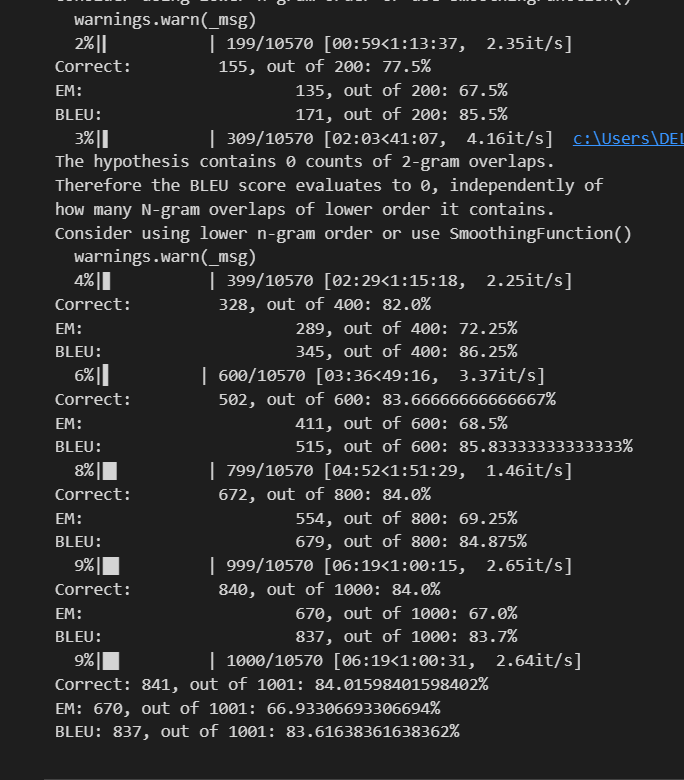
# built in:
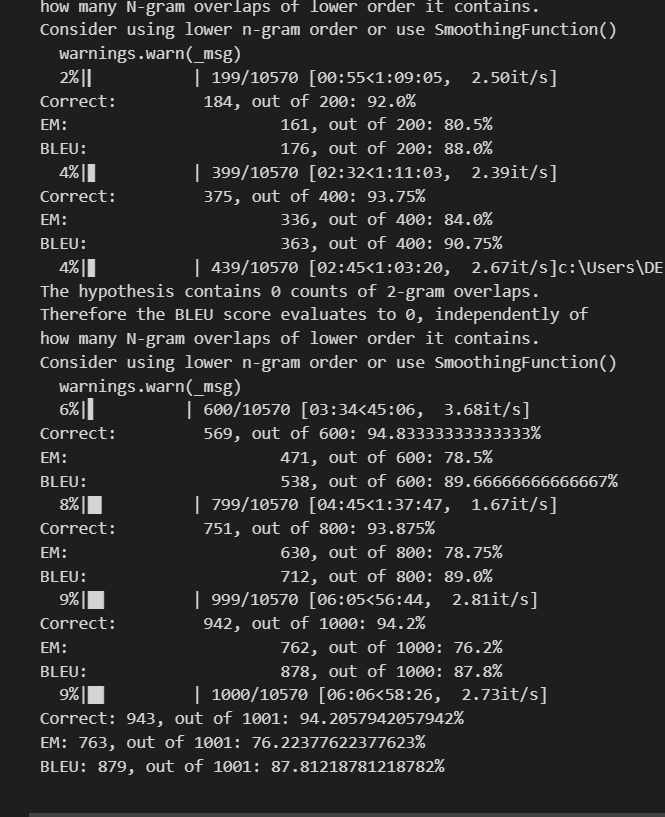

In [ ]:
pretrained_model.eval()

In [ ]:
print(pretrained_model.training)

In [ ]:
# get model architecture
print("model.config: ", pretrained_model.config)
print("============================================================================================")

# get model parameters
print("model.parameters: ", pretrained_model.parameters)
print("============================================================================================")

# get model layers
print("model.layers: ", pretrained_model.bert.encoder.layer)
print("============================================================================================")

# get model weights
# print("model.weights: ", pretrained_model.state_dict())
print("============================================================================================")

print("model.layers: ", len(pretrained_model.bert.encoder.layer))



In [ ]:
pretrained_model.eval()